Μπεκιάρης Χαράλαμπος

Σχολή ΕΜΦΕ

Α.Μ. : ge18088

# Παραδοτέο 1
## Ζήτημα 1


In [26]:
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(2017)  # for reproducibility

%matplotlib inline

def sim_anneal(f, x_low, x_high,
               T=2.0, T_min=2**(-12), 
               cool_factor=0.9, cool_sch=100,
               delta = 1.0, shrink_factor=0.5, shrink_thres=0.25,
               trace = False):
    
    # Initialize
    x = np.random.uniform(x_low, x_high)
    f_cur = f(x)  # current value of f
    steps = accepted = 0
    if trace: path = []

    # Main loop
    while T > T_min:
        
        # proposed new position
        x_new = x + np.random.uniform(-delta, delta)
        if x_new > x_high or x_new < x_low:
            continue  # skip this proposal
        f_new = f(x_new)

        # accept/reject jump
        if np.log(np.random.rand()) < -(f_new - f_cur) / T :
            x, f_cur = x_new, f_new
            accepted += 1            
                
        # Cooling
        if steps == cool_sch:  # time for the next cooling
            T *= cool_factor  # cool down
            # Adjust Search Space
            if accepted / steps < shrink_thres:
                delta *= shrink_factor
            steps = accepted = 0
        
        if trace: path.append(x)
        steps += 1        
        
    
    if trace: return path
    return x

def V(x):
    """Energy (objective) function to minimize"""
    return np.polyval((13/90, -0.3, -101/45, 13/15, 4.0), x)

x = np.linspace(-4.7, 6, 1000)


Για να βρούμε τα τοπικά ελάχιστα της V(x), την παραγωγίζουμε ως προς x και βρίσκουμε τις ρίζες. Στην συνέχεια από το γράφημα της V μπορούμε να αποφανθούμε ποιά από αυτά είναι σημεία τοπικού ελαχίστου.

V'(x) roots:  [ 3.6000464  -2.22925976  0.18690567]


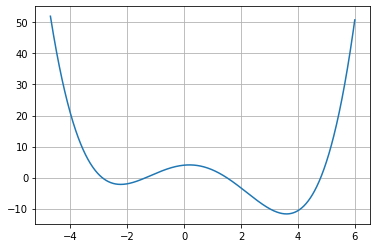

In [27]:
coeff = [26/45,-9/10,-202/45,13/15] # V'(x) coef.
print("V'(x) roots: ", np.roots(coeff))

plt.plot(x,V(x))
plt.grid(True)

Επομένως τα σημεία τοπικού ελαχίστου είναι τα `[3.6000464  -2.22925976]` και το σημείο `3.6000464` είναι ολικό ελάχιστο.

In [28]:
# Parameters
T_start, T_end = 2.0, 2**(-12)
cool_sch, cool_factor = 100, 0.99

err = 0.05
total_min =  3.6000464
local_min = -2.22925976
Nhits = {local_min: 0, total_min: 0}
for _ in range(200):
    path = sim_anneal(V, -4.7, 6., delta = 1.,
                  T = T_start, T_min = T_end,
                  cool_factor = cool_factor, 
                  cool_sch = cool_sch,
                  trace = True)  # keep the default for the rest
    est = path[-1]
    if abs(est-local_min) < err: # if particle is near the local minimum
        Nhits[local_min] += 1    #  Increase visit number by one
    if abs(est-total_min) < err: # else particle is near the global minimum
        Nhits[total_min] += 1

print("Ποσοστό % επισκέψεων στο ολικό ελάχιστο : {}%".format(Nhits[total_min]/2))
print("Ποσοστό % επισκέψεων σε τοπικό ελάχιστο : {}%".format(sum(Nhits.values())/2))


Ποσοστό % επισκέψεων στο ολικό ελάχιστο : 100.0%
Ποσοστό % επισκέψεων σε τοπικό ελάχιστο : 100.0%


In [17]:
Nhits

{-2.22925976: 0, 3.6000464: 200}

## Zήτημα 2

Η ζητούμενη εκτίμηση της πιθανότητας προσεγγίζεται από τον λόγο $Nhits/N$.

In [29]:
cool_factor = [0.25, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99] 
p = []
for cf in cool_factor:
    Nhits = 0
    for _ in range(200):
            path = sim_anneal(V, -4.7, 6., delta = 1.,
                  T = T_start, T_min = T_end,
                  cool_factor = cf, 
                  cool_sch = cool_sch,
                  trace = True)  # keep the default for the rest
            
            est = path[-1]
            if abs(est-total_min) < err:
                Nhits += 1
    p.append(Nhits/200)

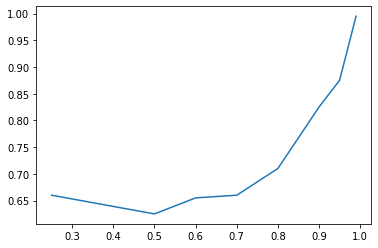

In [30]:
plt.plot(cool_factor,p)

In [31]:
for i in range(8):
    print("Cool factor {} : {} Probability".format(cool_factor[i],p[i]))

Cool factor 0.25 : 0.66 Probability
Cool factor 0.5 : 0.625 Probability
Cool factor 0.6 : 0.655 Probability
Cool factor 0.7 : 0.66 Probability
Cool factor 0.8 : 0.71 Probability
Cool factor 0.9 : 0.825 Probability
Cool factor 0.95 : 0.875 Probability
Cool factor 0.99 : 0.995 Probability


Παρατηρούμε ότι καθώς αυξάνεται η τιμή της παραμέτρου `cool_factor`, η εν λόγω πιθανότητα εύρεσης του ολικού ελαχίστου αυξάνεται εκθετικά. 

# Παραδοτέο 2

In [51]:
import csv
import urllib.request

url = "http://math.ntua.gr/~loulakis/info/python_codes_files/eu.csv"
with urllib.request.urlopen(url) as urlstream:
    csvfile = csv.reader(urlstream.read().decode('utf-8').splitlines(), delimiter=",")
    city_coord = {city: tuple(map(float, (longitude, latitude))) 
                  for longitude, latitude, city, _ in csvfile}

Ncities = len(city_coord)  # number of cities
city_names = list(city_coord.keys())

def geodesic_dist(city1, city2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    if city1 == city2:
        return 0.
    lon1, lat1 = np.deg2rad(city1)
    lon2, lat2 = np.deg2rad(city2)
    
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers 6371. Use 3956 for miles
    return c * r

# Distance between every pair of cities
dist = np.array([
    [geodesic_dist(coord1, coord2) for coord2 in city_coord.values()]
    for coord1 in city_coord.values()
])

def total_dist(cities):
    """The total distance covered by the salesman"""
    total = sum(dist[city1][city2] for city1, city2 in zip(cities[:-1], cities[1:]))
    total += dist[cities[-1]][cities[0]] # return to start
    return total

def dist_diff(ABC, XYZ, tour):
    """
    Differnce of total distance traveled if we swap cities B, Y.
    Input: 2 triplets of nodes A, B, C and X, Y, Z.
    """
    # order
    A, B, C = ABC
    X, Y, Z = XYZ
    # cities
    a, b, c = tour[ABC]
    x, y, z = tour[XYZ]
    
    BpY = (B - Y) % len(tour) # to understand the order
    dx = 0
    
    if BpY != -1 % len(tour):  #  B is not X
        dx += dist[x, b] - dist[x, y] + dist[y, c] - dist[b, c]
    if BpY != 1:  # Y is not A
        dx += dist[a, y] - dist[a, b] + dist[b, z] - dist[y, z]

    return dx



## Ζήτημα Α.

Γνωρίζουμε από την προηγούμενη άσκηση ότι αυξάνοντας το `cool_factor` η πιθανότητα εύρεσης του ελαχίστου αυξάνεται, επομένως θα δώσουμε τιμή 0.99 προκειμένουν  να πετύχουμε καλύτερη διαδρομή. Επιπλέον μπορούμε να αυξήσουμε το `cool_schedule` προκειμένου να "εξερευνεί" με περισσότερα βήματα πρωτού ελλατωθεί η θερμοκρασία. Μέχρι στιγμής η απόσταση μειώθηκε στα 22,000 km. 

Για να κερδίσουμε κάτι ακόμα, αυξάνουμε την αρχική θερμοκρασία `Temp`, προκειμένου να δώσουμε παραπάνω χρόνο για την εξερεύνηση των μεταθέσεων, και μειώνοντας το `Temp_end` ενδεχομένως να ξεχωρίσουμε τυχών ισοπαλίες που υπήρχαν σε υψηλότερες τελικές θερμοκρασίες. Η χαμηλότερη απόσταση που πέτυχα ήταν: 21,932km.

In [55]:
# Annealing Parameters
Temp = 10 ** 30
Temp_end = 0.0002
cool_factor = 0.99
cool_schedule = 400

# Bookeeping parameters
tour = np.arange(Ncities)  # initial permutation
tour_length = total_dist(tour)  # initial energy level

shortest_tour = np.copy(tour)  # optimal permutation (to be updated)
shortest_tour_length = tour_length  # shortest distance

# To plot later
first_guess = tour_length
running_lengths = []
optimal_lengths = []

# Main loop
while Temp > Temp_end:
    # Constant Temperature Era
    for step in range(cool_schedule):
        # Choose 2 cities to swap
        B, Y = np.random.choice(Ncities, size=2, replace=False)  # index of cities to swap
        ABC = np.array([B-1, B, B+1]) % Ncities  # neighbors of B
        XYZ = np.array([Y-1, Y, Y+1]) % Ncities  # neighbors of Y

        # Compute the energy diffence  
        diff = dist_diff(ABC, XYZ, tour)
        
        # Decide whether to change state.
        if np.log(np.random.rand()) < -diff / Temp:
            tour[B], tour[Y] = tour[Y], tour[B]
            tour_length += diff
            # Keep track of the optimal tour observed
            if tour_length < shortest_tour_length:
                shortest_tour = np.copy(tour)
                shortest_tour_length = tour_length

        running_lengths.append(tour_length)
        optimal_lengths.append(shortest_tour_length)

    Temp *= cool_factor  # cool down

print('Improvement:\t%8.0f%%'  % (100 * (first_guess - shortest_tour_length) / first_guess))
print('Initial distance:\t%.0f km'  % first_guess)
print('Optimal distance:\t%.0f km'  % shortest_tour_length)



Improvement:	      64%
Initial distance:	60608 km
Optimal distance:	22034 km


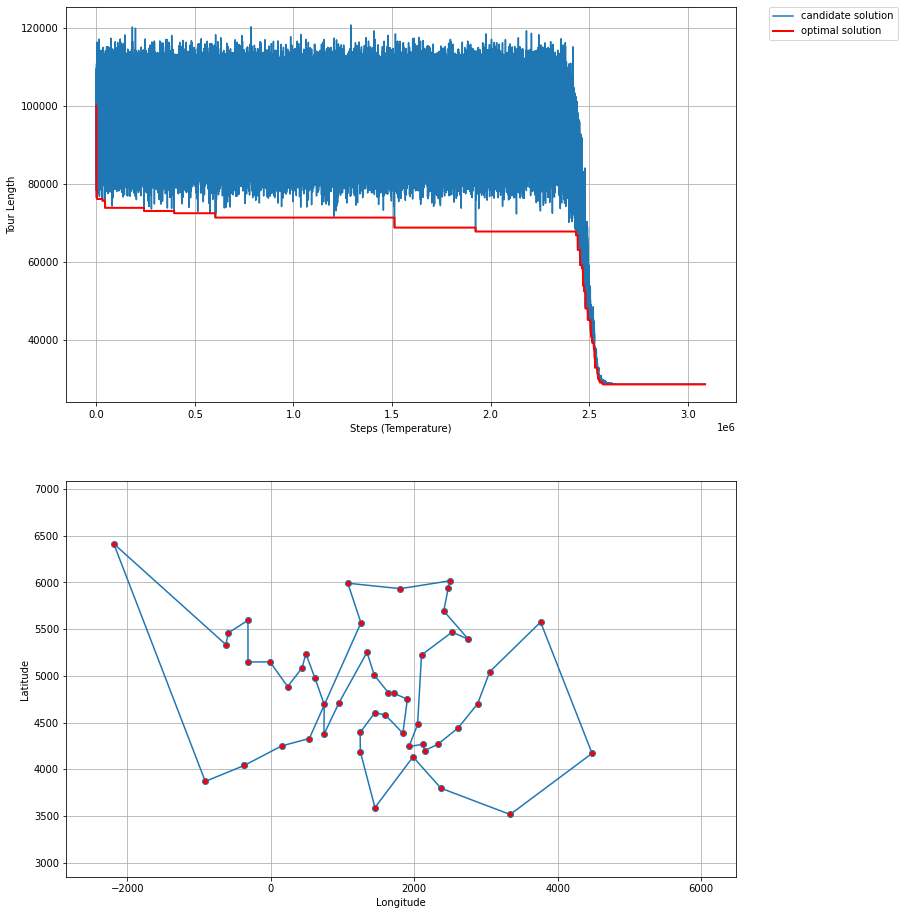

In [46]:
plt.figure(figsize=(12, 16))
plt.subplot(2, 1, 1)

running_lengths = np.array(running_lengths)
optimal_lengths = np.array(optimal_lengths)

plt.plot(np.arange(len(running_lengths)), running_lengths, label="candidate solution")
plt.plot(np.arange(len(optimal_lengths)), optimal_lengths, 'r-', linewidth=2, label="optimal solution")

plt.xlabel("Steps (Temperature)")
plt.ylabel("Tour Length")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()
##############################
plt.subplot(2,1,2)

# Get Tour Coordinates
coord = np.array([city_coord[city] for city in city_names])
cities = shortest_tour.copy()
cities = np.append(cities, cities[0])
coord = coord[cities,:]  # rearrange

# Scale for better readability
scale_factor = 100
coord = coord * scale_factor

# Plot Tour
plt.plot(coord[:, 1], coord[:,0], 'o-', mfc='r')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()

# Manage spacing
spacing = np.fabs(min(coord[:,1]) - max(coord[:,1])) * .1
plt.xlim(min(coord[:,1]) - spacing, max(coord[:,1]) + spacing * 3)
plt.ylim(min(coord[:,0]) - spacing, max(coord[:,0]) + spacing)

# Add labels - remove for more clear picture
if len(cities)<=30:
    for i, city in enumerate(cities[:-1]):
        plt.annotate('%s' % city_names[city],(coord[i,1], coord[i,0]),
                 arrowprops = {'arrowstyle':'-'}
                    )
plt.show()

##############################

## Ζήτημα Β.

In [47]:
url = "http://math.ntua.gr/~loulakis/info/python_codes_files/europe.csv"
with urllib.request.urlopen(url) as urlstream:
    csvfile = csv.reader(urlstream.read().decode('utf-8').splitlines(), delimiter=",")
    city_coord = {city: tuple(map(float, (longitude, latitude))) 
                  for longitude, latitude, city, _ in csvfile}

Ncities = len(city_coord)  # number of cities
city_names = list(city_coord.keys())

dist = np.array([
    [geodesic_dist(coord1, coord2) for coord2 in city_coord.values()]
    for coord1 in city_coord.values()
])

In [49]:
# Annealing Parameters
Temp = 10 ** 30
Temp_end = 0.0002
cool_factor = 0.99
cool_schedule = 400

# Bookeeping parameters
tour = np.arange(Ncities)  # initial permutation
tour_length = total_dist(tour)  # initial energy level

shortest_tour = np.copy(tour)  # optimal permutation (to be updated)
shortest_tour_length = tour_length  # shortest distance

# To plot later
first_guess = tour_length
running_lengths = []
optimal_lengths = []

# Main loop
while Temp > Temp_end:
    # Constant Temperature Era
    for step in range(cool_schedule):
        # Choose 2 cities to swap
        B, Y = np.random.choice(Ncities, size=2, replace=False)  # index of cities to swap
        ABC = np.array([B-1, B, B+1]) % Ncities  # neighbors of B
        XYZ = np.array([Y-1, Y, Y+1]) % Ncities  # neighbors of Y

        # Compute the energy diffence  
        diff = dist_diff(ABC, XYZ, tour)
        
        # Decide whether to change state.
        if np.log(np.random.rand()) < -diff / Temp:
            tour[B], tour[Y] = tour[Y], tour[B]
            tour_length += diff
            # Keep track of the optimal tour observed
            if tour_length < shortest_tour_length:
                shortest_tour = np.copy(tour)
                shortest_tour_length = tour_length

        running_lengths.append(tour_length)
        optimal_lengths.append(shortest_tour_length)

    Temp *= cool_factor  # cool down

print('Improvement:\t%8.0f%%'  % (100 * (first_guess - shortest_tour_length) / first_guess))
print('Initial distance:\t%.0f km'  % first_guess)
print('Optimal distance:\t%.0f km'  % shortest_tour_length)

Improvement:	      72%
Initial distance:	100118 km
Optimal distance:	27873 km


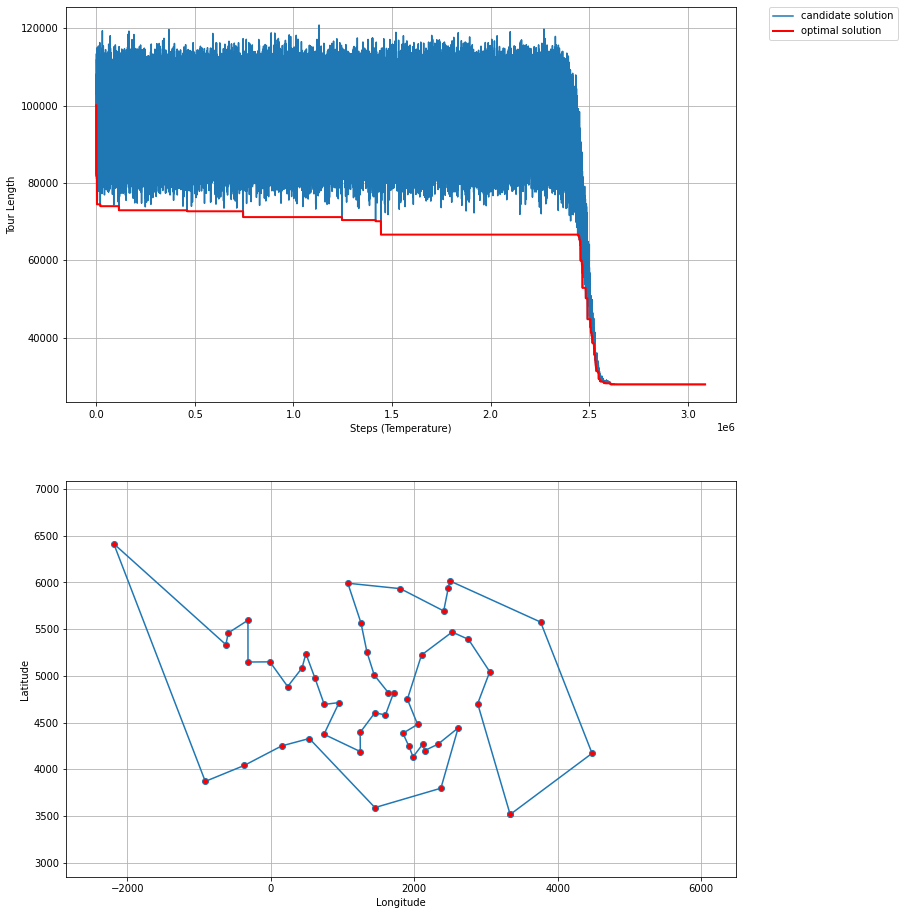

In [50]:
plt.figure(figsize=(12, 16))
plt.subplot(2, 1, 1)

running_lengths = np.array(running_lengths)
optimal_lengths = np.array(optimal_lengths)

plt.plot(np.arange(len(running_lengths)), running_lengths, label="candidate solution")
plt.plot(np.arange(len(optimal_lengths)), optimal_lengths, 'r-', linewidth=2, label="optimal solution")

plt.xlabel("Steps (Temperature)")
plt.ylabel("Tour Length")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()
##############################
plt.subplot(2,1,2)

# Get Tour Coordinates
coord = np.array([city_coord[city] for city in city_names])
cities = shortest_tour.copy()
cities = np.append(cities, cities[0])
coord = coord[cities,:]  # rearrange

# Scale for better readability
scale_factor = 100
coord = coord * scale_factor

# Plot Tour
plt.plot(coord[:, 1], coord[:,0], 'o-', mfc='r')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()

# Manage spacing
spacing = np.fabs(min(coord[:,1]) - max(coord[:,1])) * .1
plt.xlim(min(coord[:,1]) - spacing, max(coord[:,1]) + spacing * 3)
plt.ylim(min(coord[:,0]) - spacing, max(coord[:,0]) + spacing)

# Add labels - remove for more clear picture
if len(cities)<=30:
    for i, city in enumerate(cities[:-1]):
        plt.annotate('%s' % city_names[city],(coord[i,1], coord[i,0]),
                 arrowprops = {'arrowstyle':'-'}
                    )
plt.show()

##############################

## Zήτημα Γ.

### 1.
Για την πρώτη πόλη έχουμε 35 επιλογές, για την δεύτερη 34, για την τρίτη 33, ......, για την 34η πόλη έχουμε 2 επιλογές και για την 35η έχουμε 1 επιλογή. Άρα συνολικά υπάρχουν:
$$ 
35*34*...*2*1=35!
$$
διαφορετικά μονοπάτια. Άλλωστε μπορούμε να φανταστούμε τις πόλεις σαν νούμερα από το 1-35. Το κάθε μονοπάτι $σ$ αποτελεί μετάθεση των αντίστοιχων αριθμών, άρα $σ \in S_{35}$. Όπως γνωρίζουμε η τάξη της εν λόγω ομάδας μεταθέσεων είναι:
$$
|S_{35}|=35!
$$

### 2.
Ένας εξαντλητικός αλγόριθμος brute-force search θα έπρεπε να ελέγξει όλα τα μονοπάτια, επομένως θα έκανε $35!$ επαναλήψεις. Εάν ο υπολογισμός του συνολικού μήκους ενός τέτοιου μονοπατιού πραγματοποιείται σε χρόνο $1μs$, τότε συνολικά θα θέλαμε:
$$
35! * 10 μsec. ≈ 10^{40} * 10^{-6} sec. = 10^{34} sec. 
$$
ή $3.27*10^{26}$ έτη